In [1]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#### Dataset of gameweeks

In [2]:
url1 = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r1 = requests.get(url1)
generalinfo = r1.json()
generalinfo.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [3]:
# Gameweek population performance
events_df = pd.DataFrame(generalinfo['events'])
events_df_1 = events_df[['id','average_entry_score','most_selected','most_transferred_in',
                         'top_element','top_element_info','most_captained','highest_score']]
events_df_1.columns = ['gw','average_entry_score','most_selected','most_transferred_in',
                       'top_element','top_element_info','most_captained','highest_score']
events_df_2 = events_df_1[['gw','average_entry_score','highest_score']]


# club information
teams_df = pd.DataFrame(generalinfo['teams'])
teams_df_1 = teams_df[['id','name']]
teams_df_1.columns = ['team_id','team_name']

# player information
elements_df = pd.DataFrame(generalinfo['elements'])
elements_types_df = pd.DataFrame(generalinfo['element_types'])

elements_df['player_name'] = elements_df['first_name'] + " " + elements_df['second_name']
elements_df = pd.merge(elements_df, teams_df_1, left_on=['team'],right_on=['team_id'],how='left')

select_columns = ['id', 'player_name','element_type', 'now_cost', 'team_name',
                  'team_code',  'ict_index']
elements_df_1 = elements_df[select_columns]
elements_df_1.columns = ['player_id', 'player_name','element_type', 'now_cost', 'team_name',
                         'team_code',  'ict_index']

#### Dataset of my gw performances

In [4]:
url2 = 'https://fantasy.premierleague.com/api/entry/4306792/history/'
r2 = requests.get(url2)
managerhistory = r2.json()
managerhistory.keys()

dict_keys(['current', 'past', 'chips'])

In [5]:
history_df = pd.DataFrame(managerhistory['current'])
history_df.columns = ['gw','points', 'total_points', 'rank', 'rank_sort', 'overall_rank',
                      'bank', 'value', 'event_transfers', 'event_transfers_cost',
                      'points_on_bench']
history_df_1 = history_df[['gw','points','total_points','rank','overall_rank','value']]

In [6]:
history_df_2 = pd.merge(history_df_1, events_df_2, 
                        left_on=['gw'],right_on=['gw'],
                        how='left')

In [7]:
# calculate points above average 
history_df_2['points_above_avg']=history_df_2['points']-history_df_2['average_entry_score']

history_df_2['points_above_avg_percent'] = history_df_2['points_above_avg']/history_df_2['average_entry_score']
history_df_2['points_above_avg_percent'] = history_df_2['points_above_avg_percent'].round(2)

# find the rank change
history_df_2['rank_change'] = history_df_2['overall_rank'].diff()*(-1)

history_df_2['rank_change'] = history_df_2['rank_change'].fillna(8000000-1676988)
history_df_2['rank_change'] = history_df_2['rank_change'].astype(int)

history_df_2['previous_rank'] = history_df_2['overall_rank'].shift(1)
history_df_2['previous_rank'] = history_df_2['previous_rank'].fillna(8000000)

history_df_2['rank_change_percent'] = history_df_2['rank_change']/history_df_2['previous_rank']
history_df_2['rank_change_percent'] = history_df_2['rank_change_percent'].round(2)


In [8]:
history_df_2.head(22)

,gw,points,total_points,rank,overall_rank,value,average_entry_score,highest_score,points_above_avg,points_above_avg_percent,rank_change,previous_rank,rank_change_percent
0,1,85,85,1676991,1676988,1000,69,150.0,16,0.23,6323012,8000000.0,0.79
1,2,73,158,989758,905892,1003,56,146.0,17,0.30,771096,1676988.0,0.46
2,3,54,212,4064343,1187442,1004,54,119.0,0,0.00,-281550,905892.0,-0.31
3,4,58,266,3916082,1423476,1001,57,120.0,1,0.02,-236034,1187442.0,-0.20
4,5,61,327,2562959,1345547,999,55,144.0,6,0.11,77929,1423476.0,0.05
5,6,42,369,4398230,1500657,1006,43,117.0,-1,-0.02,-155110,1345547.0,-0.12
6,7,49,414,1367965,1398032,1005,38,102.0,11,0.29,102625,1500657.0,0.07
7,8,55,469,2685794,1366087,1004,49,122.0,6,0.12,31945,1398032.0,0.02
8,9,100,569,415381,812575,1002,64,165.0,36,0.56,553512,1366087.0,0.41
9,10,47,616,3028576,763664,1000,42,116.0,5,0.12,48911,812575.0,0.06


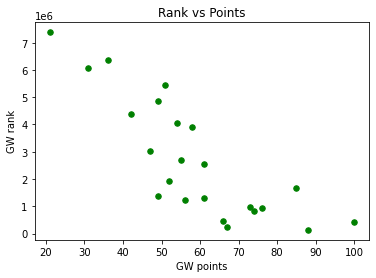

In [9]:
# GW points vs GW rank
plt.scatter(history_df_2['points'], history_df_2['rank'], color= "green", s=30)
plt.xlabel('GW points')
plt.ylabel('GW rank')
plt.title('Rank vs Points') 
plt.show()

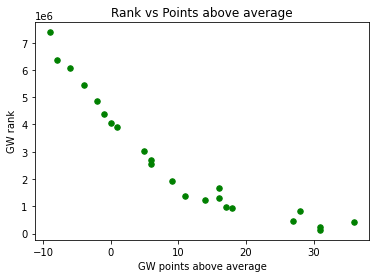

In [10]:
# GW points above average vs GW rank
plt.scatter(history_df_2['points_above_avg'], history_df_2['rank'], color= "green", s=30)
plt.xlabel('GW points above average')
plt.ylabel('GW rank')
plt.title('Rank vs Points above average') 
plt.show()

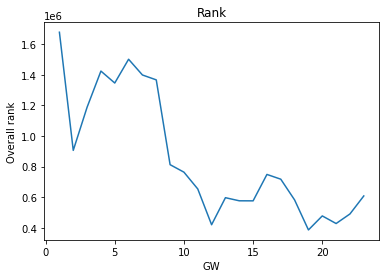

In [11]:
# Overall rank vs gameweek
plt.plot(history_df_2['gw'], history_df_2['overall_rank'])
plt.xlabel('GW')
plt.ylabel('Overall rank')
plt.title('Rank') 
plt.show()

Text(0.5, 1.0, 'Points Above Average')

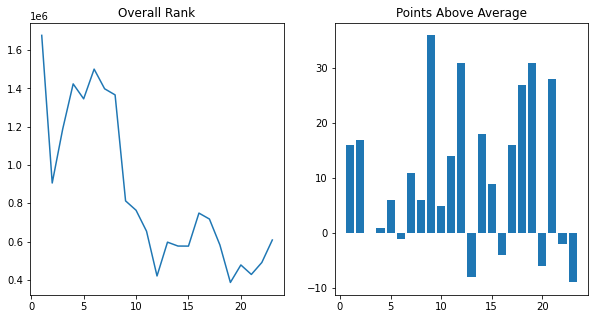

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(history_df_2['gw'], history_df_2['overall_rank'])
axs[0].set_title('Overall Rank')

axs[1].bar(history_df_2['gw'], history_df_2['points_above_avg'])
axs[1].set_title('Points Above Average')

Text(0.5, 1.0, 'Points Above Average')

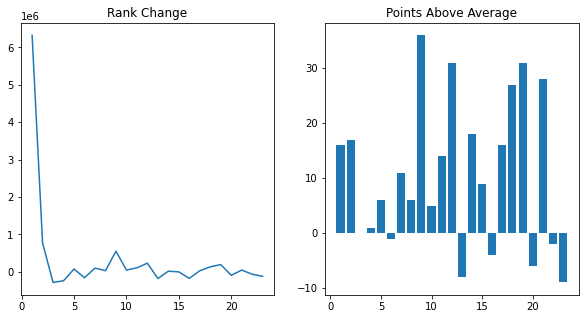

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(history_df_2['gw'], history_df_2['rank_change'])
axs[0].set_title('Rank Change')

axs[1].bar(history_df_2['gw'], history_df_2['points_above_avg'])
axs[1].set_title('Points Above Average')

Text(0.5, 1.0, 'Points Above Average %')

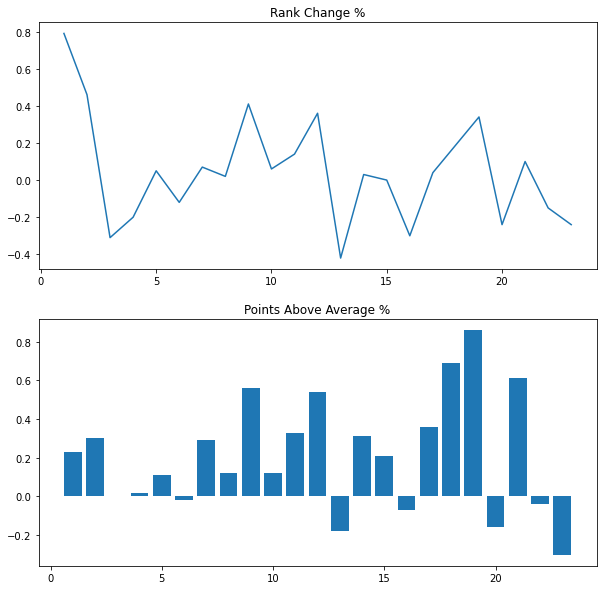

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].plot(history_df_2['gw'], history_df_2['rank_change_percent'])
axs[0].set_title('Rank Change %')

axs[1].bar(history_df_2['gw'], history_df_2['points_above_avg_percent'])
axs[1].set_title('Points Above Average %')

#### Modeling for rank percent change

In [15]:
Y = history_df_2['rank_change_percent'].head(22)
X = history_df_2[['gw','points_above_avg_percent','average_entry_score','previous_rank']].head(22)

In [16]:
X_const = sm.add_constant(X)
m1 = sm.OLS(Y, X_const).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rank_change_percent   R-squared:                       0.859
Model:                             OLS   Adj. R-squared:                  0.826
Method:                  Least Squares   F-statistic:                     25.90
Date:                 Mon, 24 Jan 2022   Prob (F-statistic):           4.86e-07
Time:                         16:25:08   Log-Likelihood:                 18.202
No. Observations:                   22   AIC:                            -26.40
Df Residuals:                       17   BIC:                            -20.95
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.3194      0.200     -1.600      0.128      -0.741       0.102
gw                          -0.0036      0.005     -0.687      0.501      -0.015       0.007
points_above_avg_percent     0.7176      0.096      7.452      0.000       0.514       0.921
average_entry_score          0.0027      0.004      0.757      0.459      -0.005       0.010
previous_rank             9.762e-08   2.17e-08      4.500      0.000    5.18e-08    1.43e-07
==============================================================================
Omnibus:                        0.689   Durbin-Watson:                   2.271
Prob(Omnibus):                  0.709   Jarque-Bera (JB):                0.266
Skew:                           0.269   Prob(JB):                        0.875
Kurtosis:                       2.974   Cond. No.                     1.52e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The overall model is valid with a significant F-statistic. Only the 'points above avg percent' and 'previous rank' has significant beta coefficient. We can interpret the other two variables to have a zero beta with the observed p-value. 

We can remove these variables for the sake of parsimony.

In [17]:
#X_const

In [18]:
Y1 = history_df_2['rank_change_percent'].head(22)
X1 = history_df_2[['points_above_avg_percent','previous_rank']].head(22)

In [19]:
X_const = sm.add_constant(X1)
m2 = sm.OLS(Y, X_const).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rank_change_percent   R-squared:                       0.847
Model:                             OLS   Adj. R-squared:                  0.831
Method:                  Least Squares   F-statistic:                     52.54
Date:                 Mon, 24 Jan 2022   Prob (F-statistic):           1.81e-08
Time:                         16:25:12   Log-Likelihood:                 17.294
No. Observations:                   22   AIC:                            -28.59
Df Residuals:                       19   BIC:                            -25.31
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2414      0.039     -6.224      0.000      -0.323      -0.160
points_above_avg_percent     0.6930      0.092      7.573      0.000       0.501       0.885
previous_rank             1.143e-07   1.65e-08      6.932      0.000    7.98e-08    1.49e-07
==============================================================================
Omnibus:                        3.777   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                2.179
Skew:                           0.741   Prob(JB):                        0.336
Kurtosis:                       3.425   Cond. No.                     7.28e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The overall AIC has improved with the two considered variables to be highly significant. 

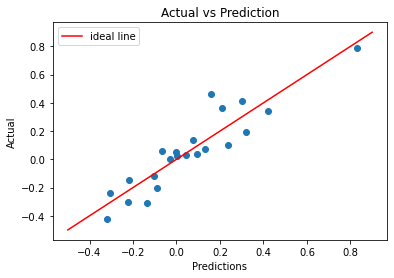

In [20]:
Y_pred = m2.predict(X_const)

x = np.linspace(-0.5,0.9,100)
y = x

plt.scatter(Y_pred, Y1)
plt.plot(y, x, '-r', label='ideal line')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Actual vs Prediction')
plt.legend(loc='upper left')
plt.show()

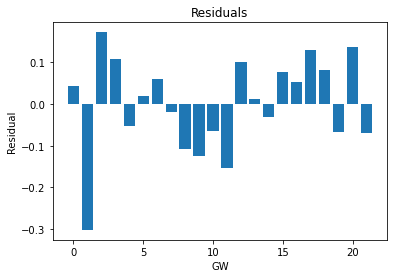

In [21]:
plt.bar(X_const.index, Y_pred - Y1)
plt.xlabel('GW')
plt.ylabel('Residual')
plt.title('Residuals') 
plt.show()

#### Prediction for next gameweek

In [22]:
pincr = [i/10 for i in range(-5,5)]
rank = [(j*250000)+250000 for j in range(12)]

In [23]:
pred_df = pd.DataFrame(index=rank, columns=pincr)

In [24]:
#pd.options.display.float_format = '{:.2f}'.format

In [25]:
def pred(inc, base_rank):
    # initialize list of lists
    test = [[1.0, inc, base_rank]]

    # Create the pandas DataFrame
    test_df = pd.DataFrame(test, columns = ['const', 'points_above_avg_percent', 
                                            'previous_rank'])

    return m2.predict(test_df)[0]

In [26]:
for i in range(pred_df.shape[0]):
    for j in range(pred_df.shape[1]):
        pred_df.iloc[i,j] = round(pred(pred_df.columns[j], pred_df.index[i]),2)
        #print(i)
        

#### GW 23 prediction

In [27]:
pred_df.style.applymap(lambda x: 'background-color : yellowgreen' if x>0 else 'background-color : wheat')
#pred_df.style.background_gradient(cmap="Spectral")

,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4
250000,-0.560000,-0.490000,-0.420000,-0.350000,-0.280000,-0.210000,-0.140000,-0.070000,-0.000000,0.060000
500000,-0.530000,-0.460000,-0.390000,-0.320000,-0.250000,-0.180000,-0.110000,-0.050000,0.020000,0.090000
750000,-0.500000,-0.430000,-0.360000,-0.290000,-0.220000,-0.160000,-0.090000,-0.020000,0.050000,0.120000
1000000,-0.470000,-0.400000,-0.340000,-0.270000,-0.200000,-0.130000,-0.060000,0.010000,0.080000,0.150000
1250000,-0.450000,-0.380000,-0.310000,-0.240000,-0.170000,-0.100000,-0.030000,0.040000,0.110000,0.180000
1500000,-0.420000,-0.350000,-0.280000,-0.210000,-0.140000,-0.070000,-0.000000,0.070000,0.140000,0.210000
1750000,-0.390000,-0.320000,-0.250000,-0.180000,-0.110000,-0.040000,0.030000,0.100000,0.170000,0.240000
2000000,-0.360000,-0.290000,-0.220000,-0.150000,-0.080000,-0.010000,0.060000,0.130000,0.200000,0.260000
2250000,-0.330000,-0.260000,-0.190000,-0.120000,-0.050000,0.020000,0.090000,0.150000,0.220000,0.290000
2500000,-0.300000,-0.230000,-0.160000,-0.090000,-0.020000,0.040000,0.110000,0.180000,0.250000,0.320000


In [28]:
pred_df.to_excel('GW23_rankelasticity.xlsx')